# imports

In [1]:
folder_name = 'models/cnns_multi_02'
num_trials = 10
testing = False
##############################################


import sys
sys.path.append('./lib')

from copy import deepcopy

import sys
import os
import h5py
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import optuna
import torch
import pickle
import dill
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from time import time

import ColorDataUtils.ConwayUtils as CU
import ColorDataUtils.EyeTrackingUtils as ETutils
import NTdatasets.conway.multi_datasets as multidata
from ColorDataUtils.multidata_utils import MultiExperiment, Experiment
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy

%load_ext autoreload
%autoreload 2

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

datadir = '/home/dbutts/ColorV1/Data/'
dirname = '/home/dbutts/ColorV1/CLRworkspace/'

class Model:
    def __init__(self, ndn_model, LLs, trial):
        self.ndn_model = ndn_model
        self.LLs = LLs
        self.trial = trial

Invoking __init__.py for NDNT.utils


# load data

In [12]:
# load data
num_lags=16

L = 60
#expt_names = ['J220715','J220722','J220801','J220808']
expt_names = ['J220715']
expts = MultiExperiment(expt_names)
expts.load(datadir, 
           num_lags=num_lags, 
           L=L, 
           tc_adjust=(15,15), 
           et_metric_thresh=0.8,
           array_type='UT',
           luminance_only=True,
           binocular=False,
           include_MUs=True,
           trial_sample=True)
data = expts.data

  FILE_INFO: stim_locsLP list again -- ok but output check
167520 total time steps, 239 units
J220715 31.4% fixations remaining
  Stim expansion for shift: [899, 474, 999, 574]
  Writing lam stim 0: overlap 60, 60
  Writing lam stim 1: overlap 60, 35
  Writing lam stim 2: overlap 32, 35
  Writing lam stim 3: overlap 32, 60
  Writing ETstim 0: overlap 8, 35
  Writing ETstim 1: overlap 8, 60
  Adding fixation point
  Shifting stim...


100%|████████████████████████████████████████████████████████████████████| 34/34 [00:21<00:00,  1.56it/s]


  CROP: New stim size: 60 x 60
  Done: expt 0
Stimulus assembly complete


In [14]:
data.NC

174

# STAs

In [3]:
stas = torch.zeros([L**2, data.NC])
nspks = torch.zeros(data.NC)
bsize = 40
lag = 4
for bb in range(len(data.block_inds)//bsize):
    ts =  np.arange(bb*bsize, (bb+1)*bsize)
    Reff = torch.mul(data[ts]['robs'], data[ts]['dfs'])
    nspks += torch.sum(Reff, axis=0)
    stas += (data[ts]['stim'][:-lag, ...].T @ Reff[lag:,:])

stas0 = (stas/nspks).reshape([L,L,data.NC]).detach().numpy()
stas0.shape

(60, 60, 585)

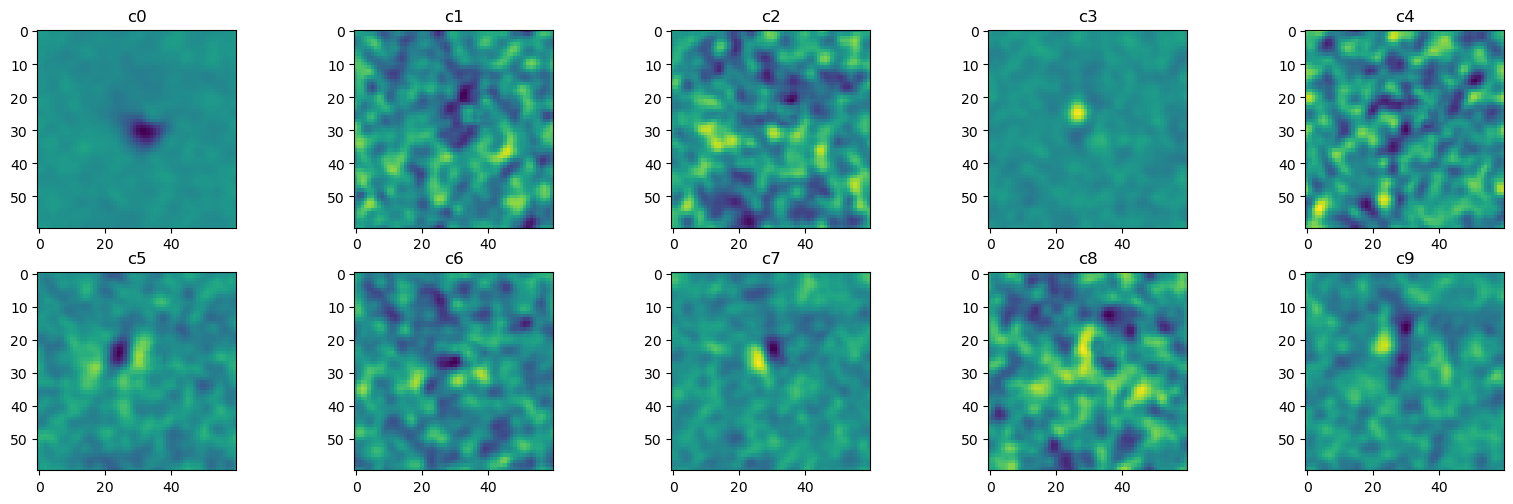

In [4]:
ss(2,5)
for cc in range(10):
    plt.subplot(2,5, cc+1)
    imagesc(stas0[:,:,cc])
    plt.title('c%d'%cc)
plt.show()

# fit model

In [3]:
# fit params
adam_parsT = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=4, num_workers=0,
    learning_rate=0.01, early_stopping_patience=10,  # changed from 4
    optimize_graph=False, weight_decay = 0.2)
adam_parsT['device'] = device
adam_parsT['accumulated_grad_batches'] = 6
if testing:
    adam_parsT['max_epochs'] = 1


# setup
data.device = device
NCv = data.NC

# assemble drift terms
NA = 0
for expt in expts:
    NA += expt.edrift.shape[0]
drift_terms = np.zeros([NA, data.NC], dtype=np.float32)
acount, ccount = 0, 0
for ee, expt in enumerate(expts):
    NAtmp = expt.edrift.shape[0]
    slicer = np.zeros([NAtmp, data.NC])
    slicer[:, range(ccount, ccount+data.fileNC[ee])] = expt.edrift
    drift_terms[range(acount, acount+NAtmp), :] = deepcopy(slicer)
    ccount += data.fileNC[ee]
    acount += NAtmp

mu0s = np.zeros([data.NC, 2])
ccount = 0
for ee, expt in enumerate(expts):
    mu0s[range(ccount, ccount+data.fileNC[ee]), :] = utils.pixel2grid(deepcopy(expt.eRFcenter[:, [1, 0]]+[15,15]), L=L)
    ccount += data.fileNC[ee]


# some good starting parameters
Treg = 0.01
Xreg = 0.000001
Mreg = 0.0001
Creg = None
Dreg = 0.5

# define model
def objective(trial):
    LGNpars = STconvLayer.layer_dict(
        input_dims = data.stim_dims,
        num_filters=4,
        num_inh=2,
        bias=False,
        norm_type=1,
        filter_dims=[1,  # channels
                     9,  # width
                     9,  # height
                     14], # lags
        NLtype='relu',
        initialize_center=True)
    LGNpars['output_norm']='batch'
    LGNpars['window']='hamming'
    LGNpars['reg_vals'] = {'d2x':Xreg,
                           'd2t':Treg,
                           'center': Creg,
                           'edge_t':100} # just pushes the edge to be sharper

    # num_subs = trial.suggest_int('num_subs', 10, 50)
    # num_inh = trial.suggest_float('num_inh', 0.1, 0.7)
    num_subs0 = trial.suggest_int('num_subs_l0', 20, 80)
    num_subs1 = trial.suggest_int('num_subs_l1', 20, 80)
    num_subs2 = trial.suggest_int('num_subs_l2', 20, 80)
    num_inh0 = trial.suggest_float('num_inh_l0', 0.1, 0.7)
    num_inh1 = trial.suggest_float('num_inh_l1', 0.1, 0.7)
    num_inh2 = trial.suggest_float('num_inh_l2', 0.1, 0.7)
    conv_l0_filter_width = trial.suggest_int('conv_l0_filter_width', 7, 39, step=2)
    conv_l1_filter_width = trial.suggest_int('conv_l1_filter_width', 5, 39, step=2)
    conv_l2_filter_width = trial.suggest_int('conv_l2_filter_width', 3, 39, step=2)
    proj_pars = ConvLayer.layer_dict(
        num_filters=num_subs0,
        bias=False,
        norm_type=1,
        num_inh=int(num_inh0*num_subs0),
        filter_dims=trial.suggest_int('proj_filter_width', 9, 29, step=2),
        NLtype=trial.suggest_categorical('proj_NLtype', ['lin', 'relu']),
        initialize_center=True)
    proj_pars['output_norm']='batch'
    proj_pars['window']='hamming'

    # conv_layer0 = STconvLayer.layer_dict(
    #     num_filters=num_subs1,
    #     num_inh=int(num_inh1*num_subs1),
    #     bias=False,
    #     pos_constraint=True,
    #     norm_type=1,
    #     conv_dims=[conv_l0_filter_width, conv_l0_filter_width, 2],
    #     NLtype='relu',
    #     initialize_center=False)
    # conv_layer0['output_norm'] = 'batch'

    conv_layer0 = ConvLayer.layer_dict(
        num_filters=num_subs1,
        num_inh=int(num_inh1*num_subs1),
        bias=False,
        pos_constraint=True,
        norm_type=1,
        filter_dims=conv_l0_filter_width,
        NLtype='relu',
        initialize_center=False)
    conv_layer0['output_norm'] = 'batch'

    conv_layer1 = ConvLayer.layer_dict(
        num_filters=num_subs1,
        num_inh=int(num_inh1*num_subs1),
        bias=False,
        pos_constraint=True,
        norm_type=1,
        filter_dims=conv_l1_filter_width,
        NLtype='relu',
        initialize_center=False)
    conv_layer1['output_norm'] = 'batch'

    conv_layer2 = ConvLayer.layer_dict(
        num_filters=num_subs2,
        num_inh=int(num_inh2*num_subs2),
        bias=False,
        pos_constraint=True,
        norm_type=1,
        filter_dims=conv_l2_filter_width,
        NLtype='relu',
        initialize_center=False)
    conv_layer2['output_norm'] = 'batch'

    # iter_layer = IterLayer.layer_dict(
    #     num_filters=num_subs,
    #     num_inh=int(num_inh*num_subs),
    #     bias=False,
    #     num_iter=trial.suggest_int('num_iter', 2, 8),
    #     output_config='full',
    #     pos_constraint=True,
    #     norm_type=1,
    #     filter_width=trial.suggest_int('iter_filter_width', 7, 47, step=2),
    #     #num_lags=2,
    #     NLtype='relu',
    #     initialize_center=False)
    # iter_layer['output_norm'] = 'batch'

    scaffold_net =  FFnetwork.ffnet_dict(
        ffnet_type='scaffold',
        xstim_n='stim',
        layer_list=[LGNpars, proj_pars, conv_layer0, conv_layer1, conv_layer2],
        scaffold_levels=[1,2,3,4])

    ## 1: READOUT
    # reads out from a specific location in the scaffold network
    # this location is specified by the mus
    readout_pars = ReadoutLayer.layer_dict(
        num_filters=NCv,
        NLtype='lin',
        bias=False,
        pos_constraint=True)
    # for defining how to sample from the mu (location) of the receptive field
    readout_pars['gauss_type'] = 'isotropic'
    readout_pars['reg_vals'] = {'max': Mreg}

    readout_net = FFnetwork.ffnet_dict(
        xstim_n = None,
        ffnet_n=[0],
        layer_list = [readout_pars],
        ffnet_type='readout')

    ## 2: DRIFT
    drift_pars = NDNLayer.layer_dict(
        input_dims=[1,1,1,NA],
        num_filters=NCv,
        bias=False,
        norm_type=0,
        NLtype='lin')
    drift_pars['reg_vals'] = {'d2t': Dreg}

    drift_net = FFnetwork.ffnet_dict(xstim_n = 'Xdrift', layer_list = [drift_pars])

    ## 3: COMB 
    comb_layer = ChannelLayer.layer_dict(
        num_filters=NCv,
        NLtype='softplus',
        bias=True)
    comb_layer['weights_initializer'] = 'ones'

    comb_net = FFnetwork.ffnet_dict(
        xstim_n = None,
        ffnet_n=[1,2],
        layer_list=[comb_layer],
        ffnet_type='add')

    cnn = NDN.NDN(ffnet_list = [scaffold_net, readout_net, drift_net, comb_net],
                  loss_type='poisson')
    cnn.block_sample = True


    ## Network 0: LGN
    # copy weights from a good LGN model
    #cnn.networks[0].layers[0] = deepcopy(cnn12.networks[0].layers[0]) # copy weights

    ## Network 1: readout: fixed mus / sigmas
    cnn.networks[1].layers[0].sample = False
    # mus and sigmas are the centers and "widths" of the receptive field center to start at
    cnn.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
    cnn.networks[1].set_parameters(val=False, name='mu')
    cnn.networks[1].set_parameters(val=False, name='sigma')

    ## Network 2: drift: not fit
    cnn.networks[2].layers[0].weight.data = torch.tensor(drift_terms, dtype=torch.float32)
    cnn.networks[2].set_parameters(val=False)

    ## Network 3: Comb
    cnn.networks[-1].set_parameters(val=False, name='weight')

    cnn.fit(data, **adam_parsT, verbose=2)
    LLs = cnn.eval_models(data, data_inds=data.val_blks, batch_size=5)

    null_adjusted_LLs = expts.LLsNULL-LLs

    cnn_model = Model(cnn, null_adjusted_LLs, trial)

    with open(folder_name+'/cnn_'+str(trial.number)+'.pkl', 'wb') as f:
        pickle.dump(cnn_model, f)

    # dump the intermediate study, but this will be off by one trial
    with open(folder_name+'/study.pkl', 'wb') as f:
        pickle.dump(study, f)

    return np.mean(null_adjusted_LLs)



study = optuna.create_study(direction='maximize')

# # enqueue initial parameters
# num_iters = [3, 5, 7]
# proj_NLtypes = ['lin', 'relu']
# for proj_NLtype in proj_NLtypes:
#     for num_iter in num_iters:
#         study.enqueue_trial(
#             {'proj_NLtype': proj_NLtype, # best = lin
#              'num_subs': 38, # best = 38
#              'num_inh': 0.4, # best = 0.4
#              'num_iter': num_iter, # best = 5
#              'proj_filter_width': 21, # best = 21
#              'iter_filter_width': 9}) # best = 9

proj_NLtypes = ['lin', 'relu']
for proj_NLtype in proj_NLtypes:
    study.enqueue_trial(
        {'proj_NLtype': proj_NLtype,
         'proj_filter_width': 17,
         'num_subs_l0': 48,
         'num_subs_l1': 48,
         'num_subs_l2': 48,
         'num_inh_l0': 0.5,
         'num_inh_l1': 0.5,
         'num_inh_l2': 0.5,
         'conv_l0_filter_width': 15,
         'conv_l1_filter_width': 9,
         'conv_l2_filter_width': 5})


study.optimize(objective, n_trials=num_trials)

# dump the final study
with open(folder_name+'/study.pkl', 'wb') as f:
    pickle.dump(study, f)

print(study.best_trial.number, study.best_params)

[I 2023-08-03 14:20:26,721] A new study created in memory with name: no-name-f24bdde1-a79c-4c89-a4bd-7479a983dd84


Model: M585_CsCCCC_R_N_A

GPU Available: True, GPU Used: True


Epoch 1:   1%|▍                            | 7/525 [00:07<09:19,  1.08s/it, train_loss=0.145]


Done fitting
  Fit complete: 9.2109375 sec elapsed


Eval models:  40%|████████████████▋                         | 42/106 [04:39<07:06,  6.66s/it]
[W 2023-08-03 14:25:15,699] Trial 0 failed with parameters: {'num_subs_l0': 48, 'num_subs_l1': 48, 'num_subs_l2': 48, 'num_inh_l0': 0.5, 'num_inh_l1': 0.5, 'num_inh_l2': 0.5, 'conv_l0_filter_width': 15, 'conv_l1_filter_width': 9, 'conv_l2_filter_width': 5, 'proj_filter_width': 17, 'proj_NLtype': 'lin'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/mattjac/anaconda3/envs/pytorch2/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_994678/3576573840.py", line 217, in objective
    LLs = cnn.eval_models(data, data_inds=data.val_blks, batch_size=5)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mattjac/projects/mattjac/v1/NDNT/NDNT.py", line 782, in eval_models
    pred = self(data_sampl

In [ ]:
LLs2 = cnn_iter.eval_models(data, mdata_inds=data.val_blks, batch_size=5)
print(np.mean(data.LLsNULL-LLs2))

In [ ]:
cnn1 = deepcopy(cnn_iter)
cnn1.plot_filters()

In [ ]:
cnn_iter = cnn_iter.to(device)

In [ ]:
LLs = cnn_iter.eval_models(data, data_inds=data.val_blks, batch_size=5)

In [ ]:
np.mean(data.LLsNULL-LLs)

In [ ]:
len(data.block_inds), np.max(data.train_blks)

In [ ]:
cnn_iter.plot_filters()

In [ ]:
# NEED TO COMPUTE NULL LLs and compare with LLsGLM
# Adapt model structure to not use ST-iter and just regular ITER, POSSIBLY WITH MORE LAYERs and/or subunits...
# Long term model play

# Tensorboard to study?

print(np.mean(data.LLsNULL-LLs))
LLsLGN_NR[:, rep] = deepcopy(data.LLsNULL-LLs)
LGNmodsNR.append(deepcopy(cnn_iter))


# tensorboard

In [4]:
import NDNT.utils.MattUtils as matt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


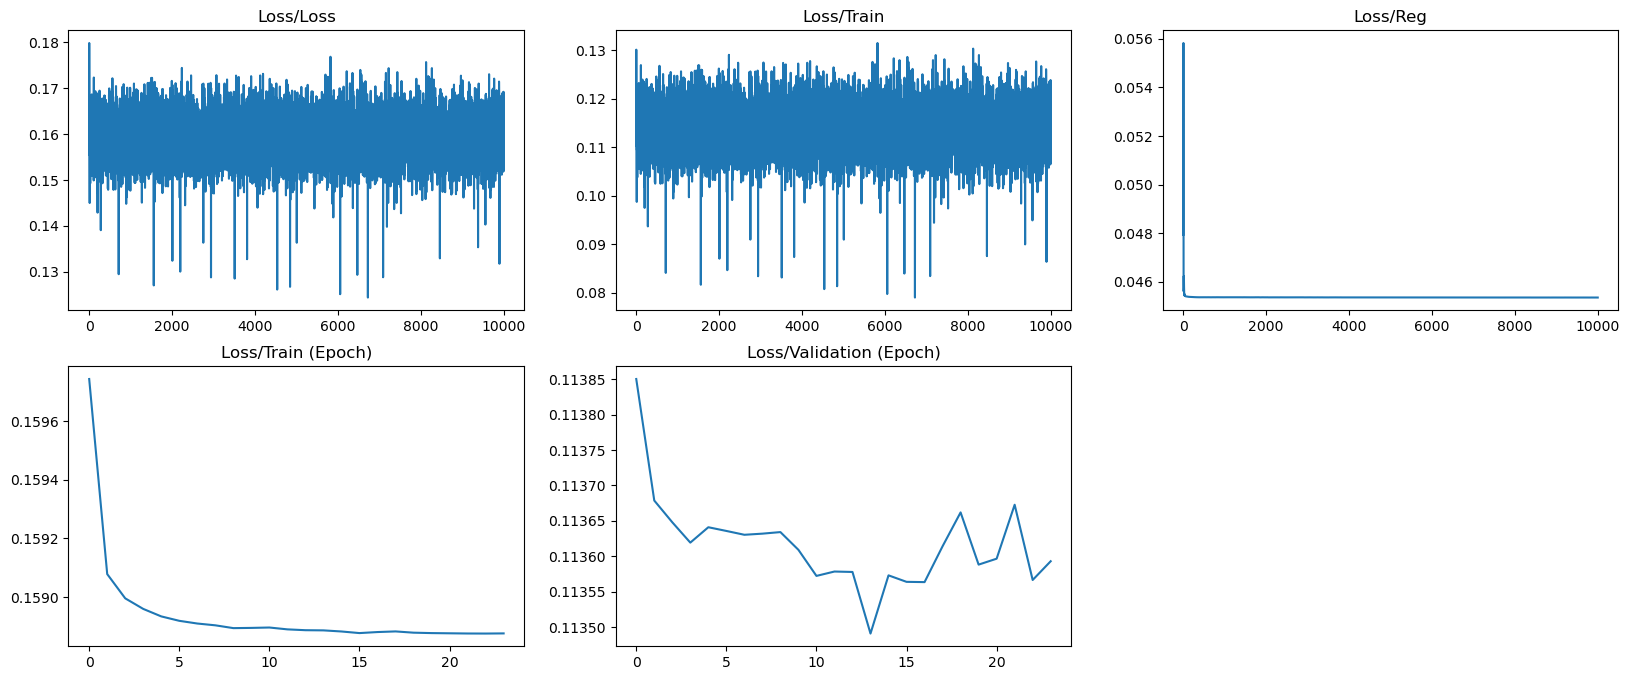

In [10]:
ckpts_directory = 'checkpoints/M585_CsCCCC_R_N_A/version5/'
matt.plot_losses(ckpts_directory, figsize=(20,8))

# load the CNN

In [6]:
#cnn_folder = 'cnns_multi_02'
cnn_folder = 'cnns_multi_0715_05'
#cnn_folder = 'cnns_07'

best trial: 0 | best LL: 0.0240752212703228


[174, 1, 1, 1]

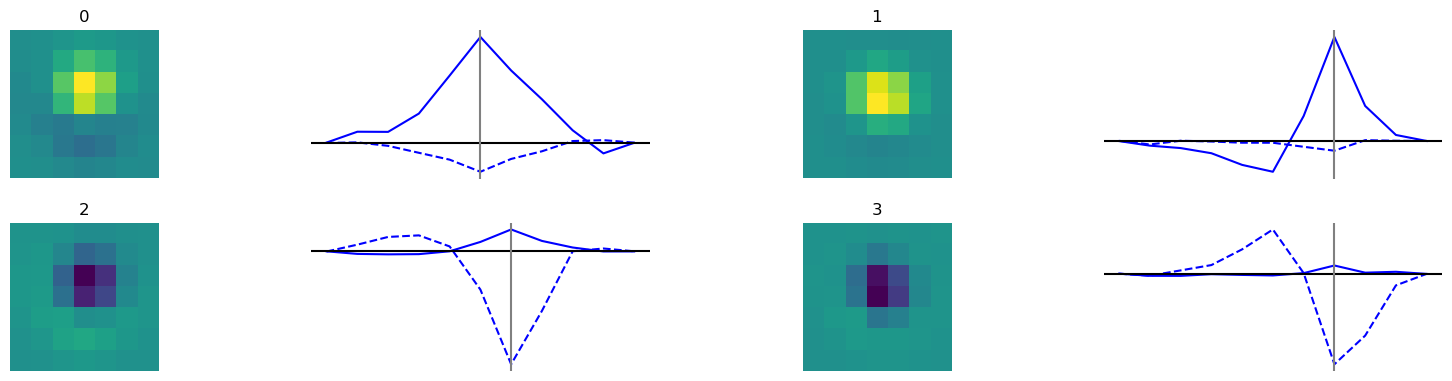

In [7]:
class Model:
    def __init__(self, ndn_model, LLs):
        self.ndn = ndn_model
        self.LLs = LLs

import pickle
cnns = []
for i in range(0,1):
    with open('models/'+cnn_folder+'/cnn_'+str(i)+'.pkl', 'rb') as f:
        cnns.append(pickle.load(f))

with open('models/'+cnn_folder+'/study.pkl', 'rb') as f:
    study = pickle.load(f)

best_cnn = cnns[study.best_trial.number].ndn_model
best_LLs = cnns[study.best_trial.number].LLs
best_trial = study.best_trial
print('best trial:', best_trial.number, '| best LL:', best_trial.value)

best_cnn.plot_filters()
best_cnn.networks[-1].layers[-1].output_dims

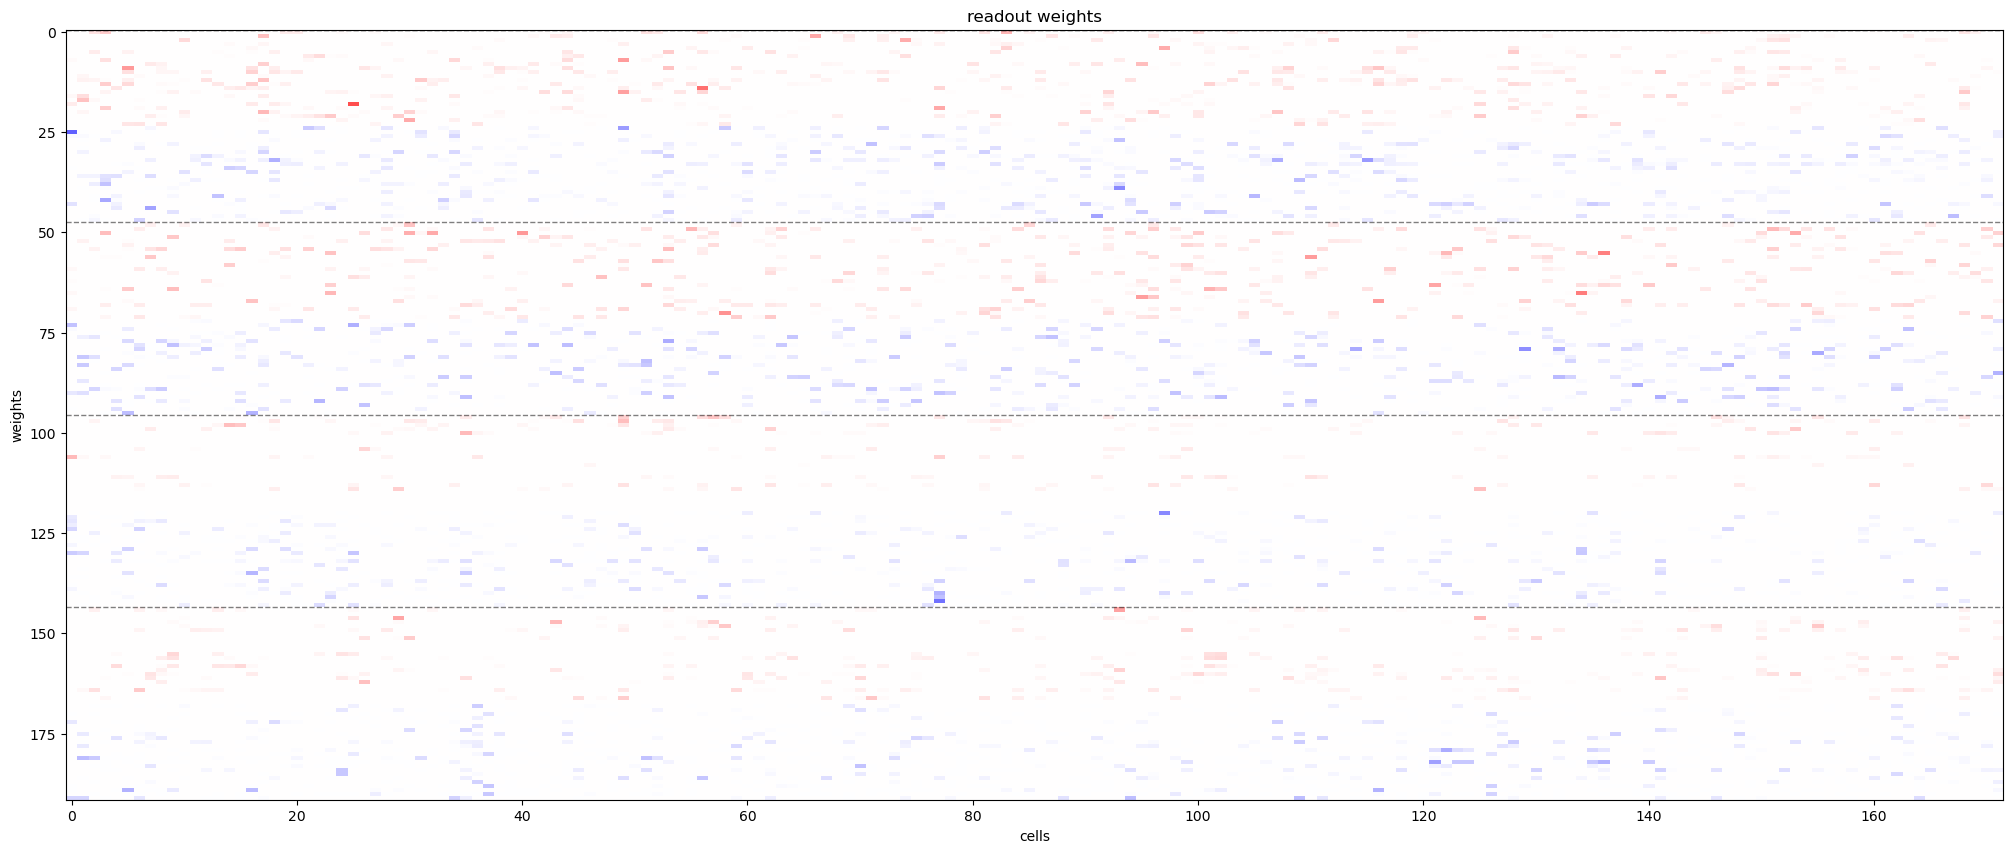

In [21]:
import ColorDataUtils.mattplotlib as mplt
_ = mplt.plot_readout_weights(model)

In [21]:
import numpy as np
np.mean(cnns[0].LLs)

0.019208265

In [ ]:
# TODO: fit a model only with 715 for comparison